In [119]:
import os
import string
import random
from typing import (Callable, List, Tuple)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchmetrics import CharErrorRate

In [120]:
!pip install torch-summary
!pip install torchmetrics

#### Константы

In [121]:
# Dataset/dataloader preprocessing
DATA_PATH = "./samples"
SPLIT_SHARE = 0.7
BATCH_SIZE = 64

# Labels preppocessing
CHARS_NUM = 5
CHARS = set(string.ascii_lowercase + string.digits)
VOCAB_SIZE = len(CHARS)
CHAR2IDX = {k: v for v, k in enumerate(CHARS)}
IDX2CHAR = {k: v for k, v in enumerate(CHARS)}

# Learning parameters
EPOCHS = 60
LEARNING_RATE = 0.002
WEIGHT_DECAY = 5e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Методы:
1) Методы для установки воспроизводимости моделей;<br>
2) Методы кодирования и декодирования целевых строк каптчи, использующиеся при обучении и тестировании модели.

In [122]:
def set_global_seed(seed: int) -> None:
    """Sets random seed into Numpy and Random, PyTorch and TensorFlow.
    Args:
        seed: random seed
    """
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    try:
        import torch_xla.core.xla_model as xm
    except ImportError:
        pass
    else:
        xm.set_rng_state(seed)
        
set_global_seed(3407)

In [123]:
def encode_labels(text_batch: List[str]) -> torch.LongTensor:
    """Set a tuple of strings
    Code it with using vocab constant"""
    text_batch_targets = [[CHAR2IDX[i] for i in label] for label in text_batch]
    text_batch_targets = torch.LongTensor(text_batch_targets)
    
    return text_batch_targets.to(DEVICE)

def weights_init(m: nn.Module) -> None:
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
def decode_labels(output_batch: torch.FloatTensor) -> List[str]:
    """Set an output with batch logits.
    Create list of captcha labels"""
    ranged_list_num = [output.softmax(1).argmax(1) for output in output_batch]
    ranged_list_char = [[IDX2CHAR[i.item()] for i in item] for item in ranged_list_num]
    result_list = [''.join(i) for i in list(map(list, zip(*ranged_list_char)))]
    return result_list

#### Подготовка dataset и dataloaders:
Класс-наследник torch.utils.data.Dataset - CaptchaDataset преобразует изображание в тензор, используя transform.<br>
Изменения, примененные к данным:<br>
1) Приведение к тензорному виду;<br>
2) Обрезание белых участков по бокам;<br>
3) Нормализация данных для удаления ассиметрии и приведения данных к определенному диапазону.<br>
##### Далее полученный датасет сплитится на трейн и тест датасеты и создаются DataLoader's для обучения/тестирования модели.


In [124]:
class CaptchaDataset(Dataset):
    
    def __init__(self, img_dir: str, transform=None, label_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform
        self.img_list = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img_full_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_full_path).convert('RGB')
        label = img_path.split(".")[0]
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)  
        return image, label

In [125]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop((50, 150)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

dataset = CaptchaDataset(DATA_PATH, transform=transform)

In [126]:
dataset_size = len(dataset)
train_size = int(SPLIT_SHARE * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### CRNN-модель
Модель взята из статьи https://arxiv.org/abs/2006.08296 и преобразована.<br>
Состоит из:<br>
1) Четырех подряд идущих комбинаций сверточного слоя, BatchNorm и MaxPool;<br>
2) Линеаризация выхода сверточной сети;<br>
3) Двунаправленная LSTM;<br>
4) Пять линейных выходов для каждого элемента на каптче.<br>

In [127]:
class CRNN(nn.Module):

    def __init__(self, chars_num, classes_num, dropout=0.33):
        super(CRNN, self).__init__()

        self.chars_num = chars_num
        self.classes_num = classes_num
        
        self.dropout = nn.Dropout(dropout)

        self.CNN = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2,2), 2),
        
            nn.Conv2d(32, 64, (5,5), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (5, 5), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), 2),
            
            nn.Conv2d(128, 128, (5, 5), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), 2),
        )
        
        self.linear_flatten = nn.Linear(896, 512)
        self.linear_bn = nn.BatchNorm1d(512)
        # rnn
        self.lstm = nn.GRU(input_size=512, 
                            hidden_size=512,
                            bidirectional=True, 
                            batch_first=True)
        self.lstm_bn = nn.BatchNorm1d(1024)
        # 5 chars in output
        self.linear_logit1 = nn.Linear(1024, classes_num)
        self.linear_logit2 = nn.Linear(1024, classes_num)
        self.linear_logit3 = nn.Linear(1024, classes_num)
        self.linear_logit4 = nn.Linear(1024, classes_num)
        self.linear_logit5 = nn.Linear(1024, classes_num)
        
    def forward(self, x): 
        x = self.CNN(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        
        x = self.linear_flatten(x)
        x = self.linear_bn(x)
        
        x, _ = self.lstm(x)
        
        x1 = self.linear_logit1(x)
        x2 = self.linear_logit2(x)
        x3 = self.linear_logit3(x)
        x4 = self.linear_logit4(x)
        x5 = self.linear_logit5(x)
        return (x1, x2, x3, x4, x5)

In [128]:
from torchsummary import summary
summary(CRNN(CHARS_NUM, VOCAB_SIZE), (3, 50, 150))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 1, 7]           --
|    └─Conv2d: 2-1                       [-1, 32, 48, 148]         2,432
|    └─BatchNorm2d: 2-2                  [-1, 32, 48, 148]         64
|    └─MaxPool2d: 2-3                    [-1, 32, 24, 74]          --
|    └─Conv2d: 2-4                       [-1, 64, 22, 72]          51,264
|    └─BatchNorm2d: 2-5                  [-1, 64, 22, 72]          128
|    └─MaxPool2d: 2-6                    [-1, 64, 11, 36]          --
|    └─Conv2d: 2-7                       [-1, 128, 9, 34]          204,928
|    └─BatchNorm2d: 2-8                  [-1, 128, 9, 34]          256
|    └─MaxPool2d: 2-9                    [-1, 128, 4, 17]          --
|    └─Conv2d: 2-10                      [-1, 128, 2, 15]          409,728
|    └─BatchNorm2d: 2-11                 [-1, 128, 2, 15]          256
|    └─MaxPool2d: 2-12                   [-1, 128, 1, 7]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 1, 7]           --
|    └─Conv2d: 2-1                       [-1, 32, 48, 148]         2,432
|    └─BatchNorm2d: 2-2                  [-1, 32, 48, 148]         64
|    └─MaxPool2d: 2-3                    [-1, 32, 24, 74]          --
|    └─Conv2d: 2-4                       [-1, 64, 22, 72]          51,264
|    └─BatchNorm2d: 2-5                  [-1, 64, 22, 72]          128
|    └─MaxPool2d: 2-6                    [-1, 64, 11, 36]          --
|    └─Conv2d: 2-7                       [-1, 128, 9, 34]          204,928
|    └─BatchNorm2d: 2-8                  [-1, 128, 9, 34]          256
|    └─MaxPool2d: 2-9                    [-1, 128, 4, 17]          --
|    └─Conv2d: 2-10                      [-1, 128, 2, 15]          409,728
|    └─BatchNorm2d: 2-11                 [-1, 128, 2, 15]          256
|    └─MaxPool2d: 2-12                   [-1, 128, 1, 7]         

### Обучение:
model_training - обучение модели. Отдельно стоит отметить необходимость введения суммы лоссов с пяти выходов для обучения.<br>
model_evaluation - результаты на всем датасете собираются в List[str] и сравниваются с использованием доли неверно распознанных признаков - CER.<br>

In [129]:
def model_training(model: CRNN
                 , dataloader: DataLoader
                 , criterion: nn.CrossEntropyLoss
                 , cer: CharErrorRate
                 , encode_function: Callable
                 , device: torch.device) -> (float, List[float]):
    """Training loop for model
    For every iteraion got 5 losses for every char in captcha
    Their sum is new variable in training process"""
    crnn.train()

    running_loss = []
    for i, (image_batch, label_batch) in enumerate(dataloader):
        
        image_batch = image_batch.to(DEVICE)
        label_batch_encoded = encode_function(label_batch)
        optimizer.zero_grad()
        outputs = crnn(image_batch)
        loss = 0
        
        for output, label in zip(outputs, label_batch_encoded.transpose(0, 1)):
              loss = loss + criterion(output, label)
        iteration_loss = loss.item()
        running_loss.append(iteration_loss)
        loss.backward()
        optimizer.step()
    epoch_loss = np.mean(running_loss)
    return epoch_loss, running_loss
    

def model_evaluation(model: CRNN
                   , dataloader: DataLoader
                   , criterion: nn.CrossEntropyLoss
                   , cer: CharErrorRate
                   , encode_function: Callable
                   , decode_function: Callable
                   , device: torch.device) -> (float, float):
    """CrossEntropyLoss calculation same as train.
    Results of predicted lists of strings extend in one list of captcha labels
    and them are compared with true-labels list with using CharErrorRate"""
    trues = []
    preds = []
    running_loss = []
    
    model.eval()
    with torch.no_grad():
        for i, (image_batch, label_batch) in enumerate(dataloader): 
            image_batch = image_batch.to(DEVICE)
            label_batch_encoded = encode_function(label_batch)
            outputs = model(image_batch)
            label_pred = decode_function(outputs)
            
            loss = 0
            for output, label in zip(outputs, label_batch_encoded.transpose(0, 1)):
                loss = loss + criterion(output, label)
            iteration_loss = loss.item()
            running_loss.append(iteration_loss)
            
            trues.append(label_batch)
            preds.append(label_pred)
    trues = [i for sub in trues for i in sub]
    preds = [i for sub in preds for i in sub]
    
    epoch_loss = np.mean(running_loss)
    test_epoch_cer = cer(trues, preds).item()
    
    return epoch_loss, test_epoch_cer 

In [130]:
crnn = CRNN(CHARS_NUM, VOCAB_SIZE)
crnn.apply(weights_init)
crnn = crnn.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(crnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

cer = CharErrorRate()

In [131]:
epoch_losses = []
iteration_losses = []
test_epoch_losses = []
test_epoch_cer = []

for epoch in range(1, EPOCHS+1):
    train_epoch_loss_list = []
    test_epoch_loss_list = []
    
    train_loss, train_list_losses = model_training(crnn
                                                 , train_dataloader
                                                 , criterion
                                                 , cer
                                                 , encode_labels
                                                 , DEVICE)
    test_loss, test_cer = model_evaluation(crnn
                               , test_dataloader
                               , criterion
                               , cer
                               , encode_labels
                               , decode_labels
                               , DEVICE) 
    print("""Epoch: {}, Train loss: {}, Test loss: {}, Test CER: {}"""\
          .format(round(epoch, 4), round(train_loss, 4), round(test_loss, 4), round(test_cer, 4)))
    epoch_losses.append(train_loss)
    iteration_losses.extend(train_list_losses)
    test_epoch_losses.append(test_loss)
    test_epoch_cer.append(test_cer)
    
    # stop training after good results
    if test_cer <= 0.05:
        break

Epoch: 1, Train loss: 13.4448, Test loss: 18.7888, Test CER: 0.8891
Epoch: 2, Train loss: 5.1851, Test loss: 13.0962, Test CER: 0.7227
Epoch: 3, Train loss: 1.5732, Test loss: 4.6081, Test CER: 0.2947
Epoch: 4, Train loss: 0.4714, Test loss: 3.5115, Test CER: 0.1925
Epoch: 5, Train loss: 0.1662, Test loss: 2.3328, Test CER: 0.1315
Epoch: 6, Train loss: 0.0745, Test loss: 2.1837, Test CER: 0.1109
Epoch: 7, Train loss: 0.0444, Test loss: 3.7635, Test CER: 0.1065
Epoch: 8, Train loss: 0.0331, Test loss: 1.6086, Test CER: 0.104
Epoch: 9, Train loss: 0.0249, Test loss: 1.7259, Test CER: 0.0947
Epoch: 10, Train loss: 0.0226, Test loss: 1.6967, Test CER: 0.0941
Epoch: 11, Train loss: 0.0203, Test loss: 1.5018, Test CER: 0.0991
Epoch: 12, Train loss: 0.0184, Test loss: 1.7386, Test CER: 0.0903
Epoch: 13, Train loss: 0.0174, Test loss: 1.5958, Test CER: 0.091
Epoch: 14, Train loss: 0.0169, Test loss: 1.5301, Test CER: 0.0847
Epoch: 15, Train loss: 0.0171, Test loss: 1.4976, Test CER: 0.0897
Epo

#### Графики:
1) График CrossEntropyLoss в разбивке по итерациям и эпохам;<br>
2) График CrossEntropyLoss для train и test датасетов;<br>
3) График CER для test-датасета.

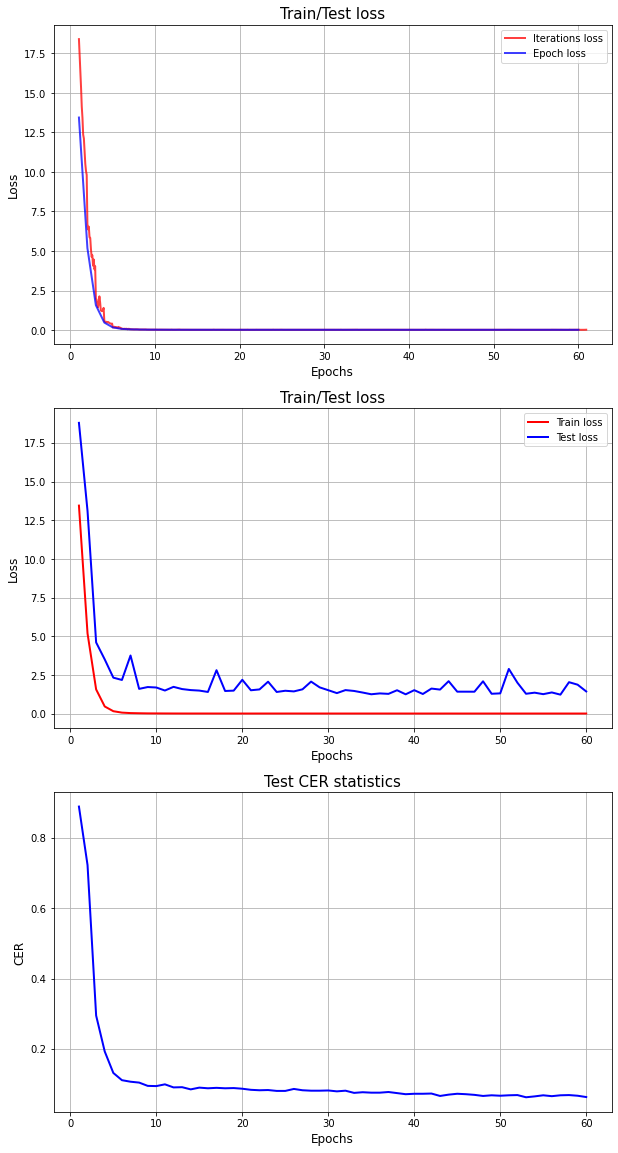

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))

xrange = np.arange(1, epoch+1)
iteration_xrange = np.arange(1, epoch+1, 1/len(train_dataloader))

ax1.plot(iteration_xrange, iteration_losses, 'r', linewidth=2, alpha=0.75, label='Iterations loss')
ax1.plot(xrange, epoch_losses, 'b', linewidth=2, alpha=0.75,  label='Epoch loss')
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title('Train/Test loss', fontsize=15)
ax1.grid()
ax1.legend()

ax2.plot(xrange, epoch_losses, 'r', linewidth=2, label='Train loss')
ax2.plot(xrange, test_epoch_losses, 'b', linewidth=2, label='Test loss')
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title('Train/Test loss', fontsize=15)
ax2.grid()
ax2.legend()

ax3.plot(xrange, test_epoch_cer, 'b', linewidth=2)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("CER", fontsize=12)
ax3.set_title('Test CER statistics', fontsize=15)
ax3.grid()

plt.show()

#### Посмотрим отдельно на частоту несовпадений в labels и примеры с самыми высокими несовпадениями символов в каптче.
Финальное значение CER для тестового датасета равно 6,29%. Согласно гистограмме частот ошибок, при тестировании нет каптч, в которых допущено 4 или 5 ошибок, что не может не радовать. <br>
При рассмотрении каптч и целевых строк, видно, что проблемой обучения является визуальное совпадение некоторых символов при вращении и зашумленности на каптче. <br>
Символы, которые чаще всего путаются друг с другом: [b, 5, 6, 8, 2], [2, g, 9, p], [w, y, u], [b, d, p]. <br>
Возможным решением проблемы наличия ошибок может быть отдельно проведенный feature engineering над целевым датасетом или применение более узконаправленных методов для задачи распознавания CAPTCHA, например, https://theailearner.com/tag/crnn-model/.


In [133]:
def count_difference(first: str, second: str) -> int:
    cnt = 0
    for f, s in zip(first, second):
        cnt = cnt + 1 if f != s else cnt
    return cnt

In [134]:
def collect_error(model: CRNN
                , dataloader: DataLoader
                , encode_function: Callable
                , decode_function: Callable
                , device: torch.device) -> dict:
    """CrossEntropyLoss calculation same as train.
    Results of predicted lists of strings extend in one list of captcha labels
    and them are compared with true-labels list with using CharErrorRate"""
    error_dict = {1: []
                , 2: []
                , 3: []
                , 4: []
                , 5: []}
    
    model.eval()
    with torch.no_grad():
        for i, (image_batch, label_batch) in enumerate(dataloader): 
            image_batch = image_batch.to(DEVICE)
            label_batch_encoded = encode_function(label_batch)
            outputs = model(image_batch)
            label_pred = decode_function(outputs)
            for tensor, true, pred in zip(image_batch, label_batch, label_pred):
                if count_difference(true, pred) != 0:
                    error_dict[count_difference(true, pred)].append((tensor
                                                                   , true
                                                                   , pred))
    return error_dict 

In [135]:
error_dict = collect_error(crnn
                         , test_dataloader
                         , encode_labels
                         , decode_labels
                         , DEVICE) 

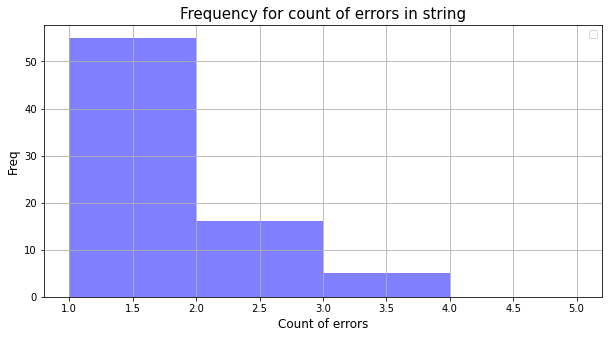

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist([1] * len(error_dict[1]) +
         [2] * len(error_dict[2]) +
         [3] * len(error_dict[3]) + 
         [4] * len(error_dict[4]) +
         [5] * len(error_dict[5])
       , bins=[1, 2, 3, 4, 5]
       , facecolor='blue'\
       , alpha=0.5)
ax.set_xlabel("Count of errors", fontsize=12)
ax.set_ylabel("Freq", fontsize=12)
ax.set_title('Frequency for count of errors in string', fontsize=15)
ax.grid()
ax.legend()


plt.show()

True label = c3572, predicted label = c352x


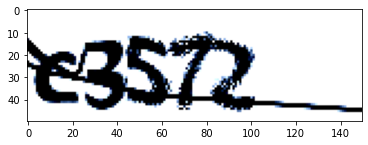

True label = f2fge, predicted label = f25gx


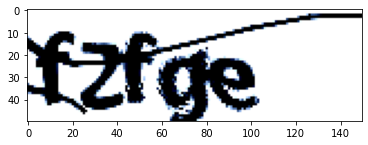

True label = mfb3x, predicted label = mff2x


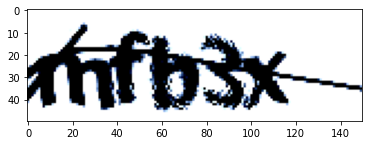

True label = ef4mn, predicted label = ef4nm


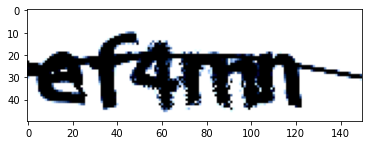

True label = egxmp, predicted label = ygxmm


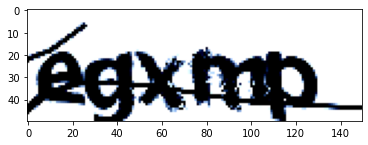

True label = 6xxdx, predicted label = 6xx2e


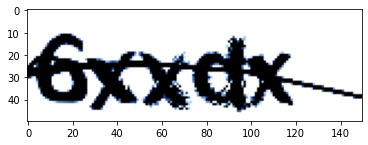

True label = mc35n, predicted label = mmc5n


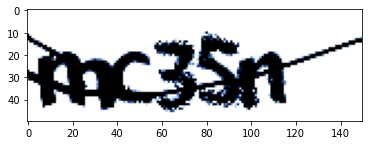

True label = m3588, predicted label = m7b88


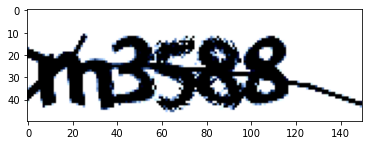

True label = wxy4n, predicted label = wxcen


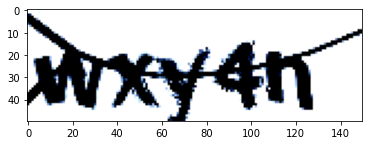

True label = mp7wp, predicted label = mm7wg


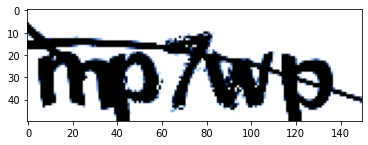

True label = m2nf4, predicted label = m3mf4


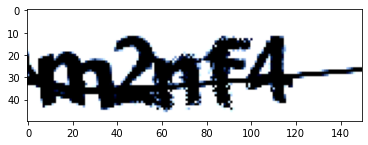

True label = cm6yb, predicted label = cmwyd


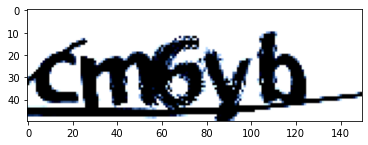

True label = wmpmp, predicted label = wmmmm


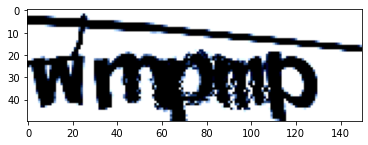

True label = wce5n, predicted label = wmeen


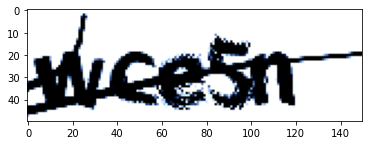

True label = yx2d4, predicted label = y5224


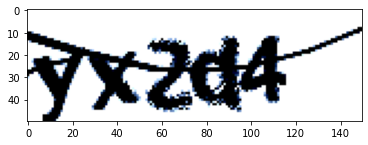

True label = wf684, predicted label = w4n84


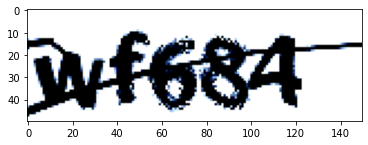

True label = mx8bb, predicted label = mmc8b


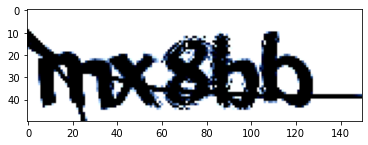

True label = xwx7d, predicted label = xwcy5


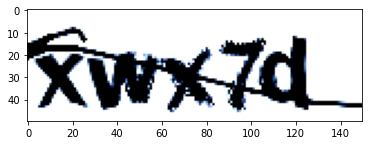

True label = m4g8g, predicted label = m4828


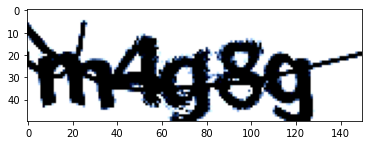

True label = men4f, predicted label = mnmnf


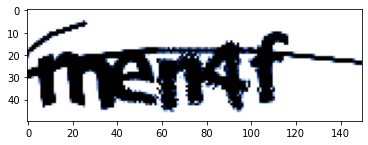

True label = c55c6, predicted label = c5x6p


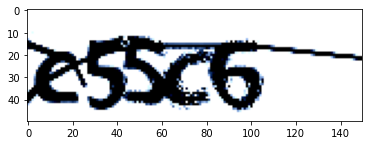

In [137]:
for (image, true, false) in error_dict[2] + error_dict[3]:
    print(f"True label = {true}, predicted label = {false}")
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.show()